# 001 - Basic Layer 2 (and 2.5!) and Layer 3 Connectivity

The goal if this demo is to demonstrate what happens when you have a 2 or 3 machines connected together
within a Local Area Network (LAN) using only a switch (no routers).

You will see the following protocols in action:
* Ethernet
* ARP (Address Resolution Protocol) for IP Version 4 (IPv4)
* IP (Internet Protocol)
* ICMP (Internet Control Message Protocol)

In addition, I hope you will start to get a sense of how the layering of network protocols work and, more importantly,
why the layering is useful and even necessary.

In [1]:
from routersim.topology import Topology
from simhelpers import topology_diagram
from simhelpers import frame_sequence,packet_sequence
from IPython.display import Image

Let's connect a couple things together and see what it looks like

In [2]:

homenetwork = Topology("My LAN")

switch = homenetwork.add_switch("sw1")
pc1 = homenetwork.add_server("pc1")
pc2 = homenetwork.add_server("pc2")

# By default within this network sim, the first interface will
# be called et1. You could of course use 'eth0' or whatever
# you might prefer.
# The reason it is set up this way is that this simulator started out
# as a means of simulating some features in Juniper routers, and they
# use the `et` naming.
pc1.add_ip_address('et1', '192.168.1.100/24')
pc2.add_ip_address('et1', '192.168.1.200/24')

switch.interface('et1').connect(pc1.interface('et1'), latency_ms=1)
switch.interface('et2').connect(pc2.interface('et1'), latency_ms=1)

Aside from directly connecting our systems, we have made the simplest possible link between two hosts.

Let's see how it looks by using some helpers built into the simulator that let's you display an inline
image of your "topology".

By default we will show both the "Layer 2" (e.g. Ethernet) physical link and address as well as the
"Layer 3" (Network = IP) logical interfaces and addresses. This might be a bit different than you 
are used to, but you can treat `et1` and `et1.0` for now as being the same thing that has both 
a MAC address and an IP address. 

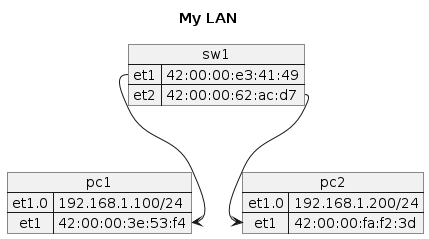

In [3]:
display(
    Image(
topology_diagram(homenetwork.name, homenetwork.get_topology()).png()
    )
)

At this point I think we are ready to send a message between the two hosts.

Naturally, we will do this will a "ping".

We are going to from pc1 (`192.168.1.100`) to pc2 (`192.168.1.200`)

In [4]:
pc1.ping('192.168.1.200',count=1)


PING 192.168.1.200


Oh no, nothing has happened!

So this is the first time we run into a bit of needing know a small bit about how this simulator works.

Any time you want to perform some set of actions, you first set them up and then you let the simulator know
that you would like to perform some number of "ticks". You can also tell it how many simulated milliseconds
you would like to proceed.

Every time a series of ticks are run, "events" are generating representing all that has occurred. You can then
analyze, display, filter, whatever those events.


In [5]:
# As we set up 1ms latency between the systems, running for (simulated) 100ms should be plenty
events = homenetwork.run_another(100)

	Received reply from 192.168.1.200 - 8.0 ms


Neat! During that run, pc1 actually got the ping reply from pc2 (192.168.1.200) and it is rendered in
something like what you might be used to seeing when you execute a standard ping.

Now let's use another feature of the simulator, which is generation of sequence diagrams based on the contained
events.

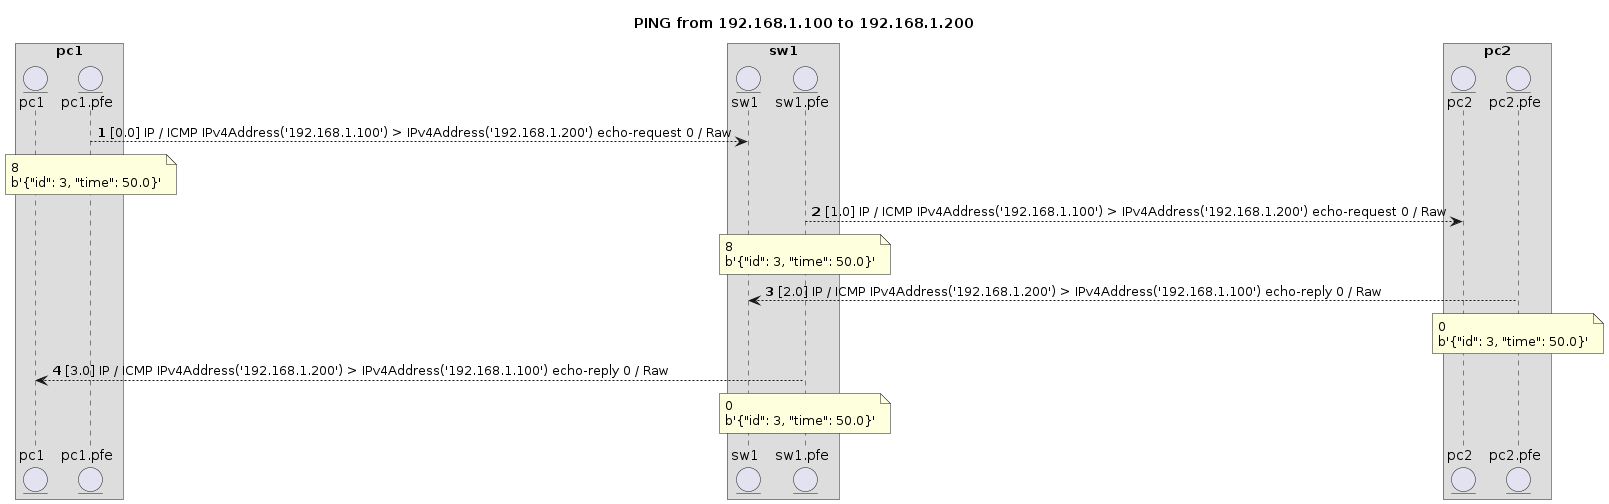

In [6]:
display(
    Image(
        packet_sequence(
            "PING from 192.168.1.100 to 192.168.1.200", 
            [pc1, switch, pc2],
            filter(
                lambda evt:str(evt[1].event_type) == 'PACKET_SEND' and str(evt[1].object.type) == 'IPV4', events
            )
        ).png()
    )
)

A quick note about the usage of `.pfe` in the diagram. Since this code really started out as a router simulator, it has
internal separation of the "control plane" of the device from the "forwarding plane",
which is known as the Packet Forwarding Engine (PFE) on Juniper devices. On true network gear, most frames and packets
will flow through the device without ever entering on the "control plane" (think of it like a computer) of the network gear.

Of course, the diagram as presented ends up making things confusing because I show the frames/packets arriving at, say
`sw1` and exiting at `sw1.pfe` which is, ideally, quite incorrect as instead it should be all PFE. This is a weakness in my current
code for generating the diagrams, which I do intend on fixing!



Alright, so this probably looks a bit like what you would expect:

1. PC1 sends an ICMP `EchoRequest` to 192.168.1.200 with id=3
2. SW1 forwards the ICMP `EchoRequest` to PC2
3. PC2 Sends an ICMP `EchoReply` matching the id of the `EchoRequest` (3) back to pc1 (192.168.1.100)
4. SW1 forwards the ICMP `EchoReply` to PC1

But is it really that simple? You might perhaps wonder... 

How did PC1 know where to send the actual message to PC2? 
How did PC2 know where to send the response back to PC1?

Or perhaps you might think (as I always had), "What do you mean? The message was sent directly to the IP address, of course it arrived!"

But recall that we did not attach the hosts to a router, but a simple switch. Switches operate at Layer 2 (Link = Ethernet), which 
has no need or concern for anything so high level as an IP address, which is way up in the stratosphere of Layer 3 (Network). Switches
are concerned only with sending `frames` between physical links (e.g Cat-5 cables) connected to its ports.

Given that, this makes more specific our initial question: How did PC1 know the MAC address of PC1?


Let's look at the complete set of packets that were sent during the ICMP Request/Reply sequence and
see what we can discover!

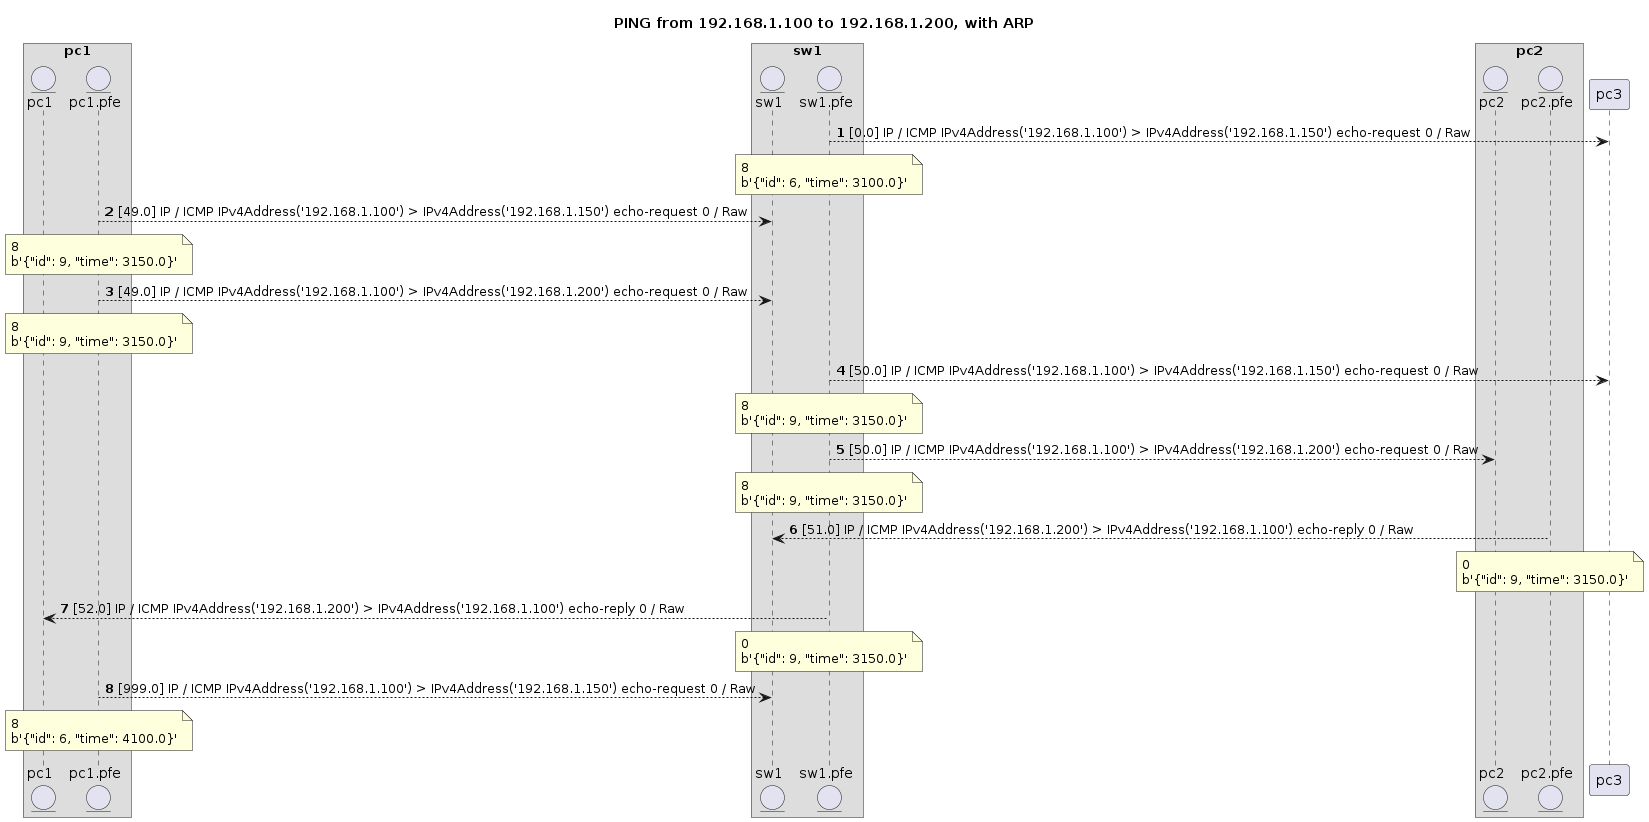

In [16]:
display(
    Image(
        packet_sequence(
            "PING from 192.168.1.100 to 192.168.1.200, with ARP", 
            [pc1, switch, pc2],
            events,
        ).png()
    )
)

Looks mostly familiar, but now the ICMP portion of the sequence is preceded by some `ARP` messages.

`ARP` stands for [Address Resolution Protocol](https://en.wikipedia.org/wiki/Address_Resolution_Protocol), and it was designed specifically for the problem we described above: Determine the Link Layer (Ethernet) address (aka the MAC Address) associated with a Network Layer (IP) address.

As you can see above, before sending out the ICMP packets we have:

1. PC1 sends out an ARP `Request` asking for the MAC address of 192.168.1.200, and includes a return address for the info
2. SW1 forwards that ARP `Request` through to PC2
3. PC2 sends an ARP `Response` with its MAC address (42:00:00:46:9c:53 here)
4. SW1 forwards that ARP `Response` through to PC1
5. PC1 *now* can send the ICMP `EchoRequest`, which is now addressed to PC1's `et1` MAC Address
6. Sequence proceeds as above


You could perhaps find yourself wondering why PC2 didn't send an ARP `Request` for the IP Address of PC1 (192.168.1.100)
in order to send its reply. Think about why it might not need do that...

...

Recall that the only reason to send an ARP `Request` is because you have no idea what MAC (Layer 2) address goes with the IP Address (Layer 3).
Helpfully, the `Request` in fact contains enough information that the receiver of that ARP `Request` can treat it *as if* it was a `Reply` that
it received from a hypothetical future ARP `Request`. In other words, PC2 sees the "return address" in the ARP Request, and makes the assumption
that when it wants to send a message to 192.168.1.200 it can use the "at" address from the request. Pretty neat, huh? 

Can you think of any potential security issues with how ARP operates by default? Consider looking into how your oeprating system of choice
mitigates potential issues. Network devices (switches and routers) also have mechanisms to help mitigate the risks.

Final bit of trivia: ARP is often considered a Layer "2.5" protocol because it acts as a glue between Layer 2 and Layer 3

We aren't *quite* done with our discussion of basic Layer 2 and Layer 3 connectivity.

In the diagram above, we showed how PC1 and PC2 figured out how to learn each other's MAC address so they can get IP packets to each other.

But the diagram also glosses over the fact that SW1 itself somehow had to get all the frames to the right port. 

Consider the situation of a 3rd PC hooked up to the switch. What do you think would happen when PC1 needed to reach PC3?
Where would the switch send the ARP messages to? What mechanism would *you* use in order for the switch to ensure the initial request messages
went to the right place?

Let's actually create that situation and see what it looks like and then later (and finally) we will look one step lower at the Layer 2 messages.

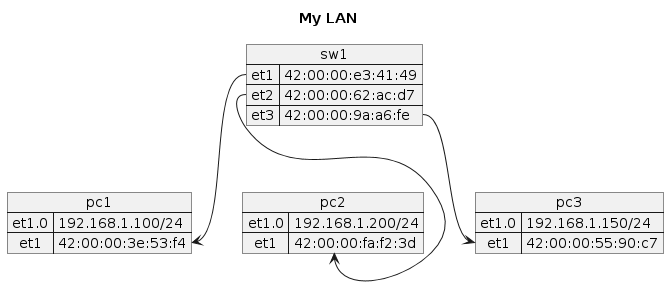

In [7]:
pc3 = homenetwork.add_server("pc3").add_ip_address('et1', '192.168.1.150/24')
switch.interface('et3').connect(pc3.interface('et1'), latency_ms=1)
display(
    Image(
topology_diagram(homenetwork.name, homenetwork.get_topology()).png()
    )
)

In [8]:
pc1.ping('192.168.1.150')

# just like last time, we'll step through 100ms or so
events2 = homenetwork.run_another(100)


PING 192.168.1.150
	Received reply from 192.168.1.150 - 8.0 ms


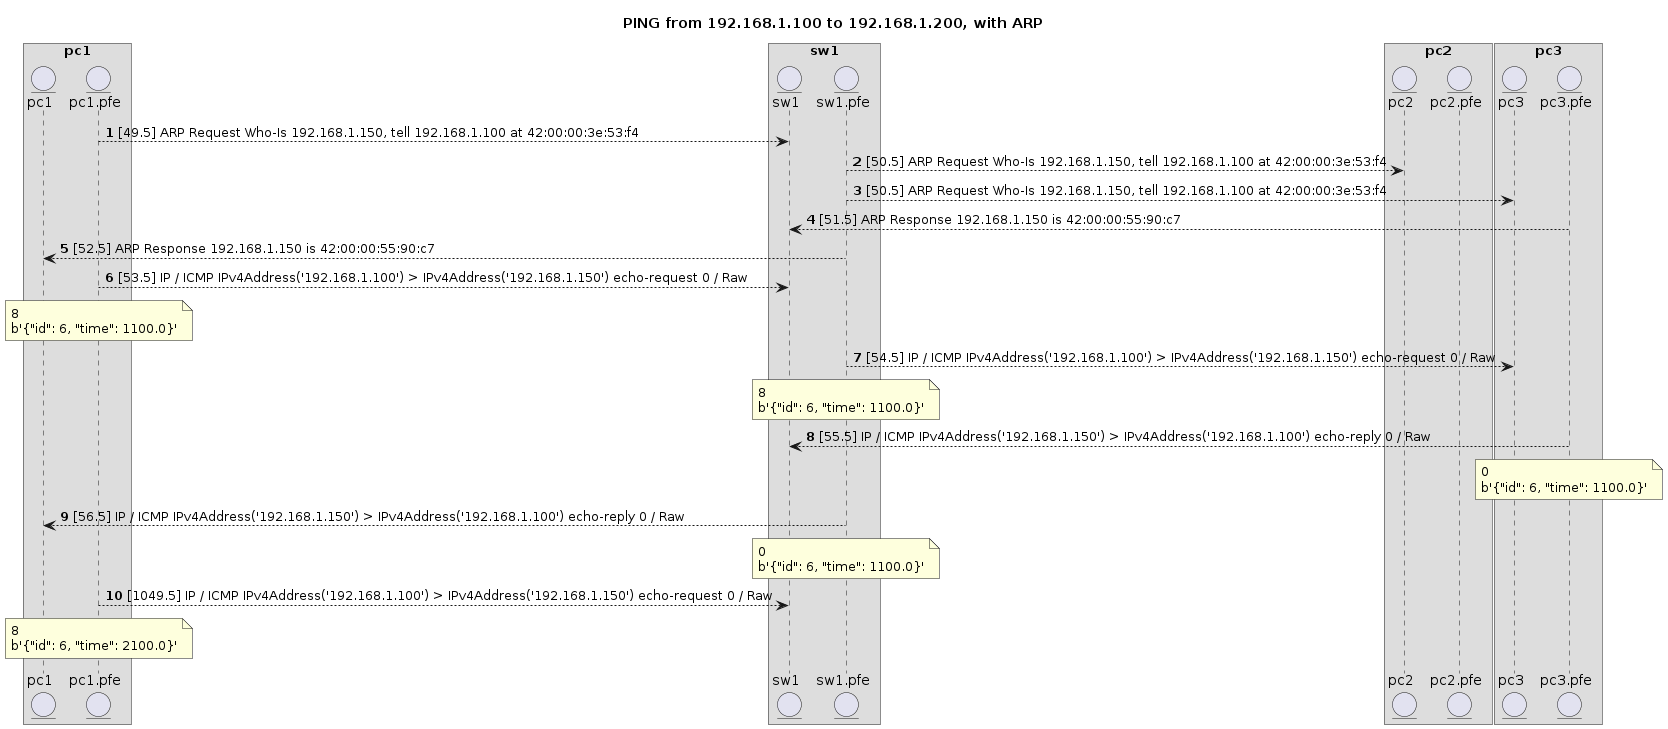

In [9]:
display(
    Image(
        packet_sequence(
            "PING from 192.168.1.100 to 192.168.1.200, with ARP", 
            [pc1, switch, pc2, pc3],
            events2,
        ).png()
    )
)

Is that what you expected?

Notice in steps 2 and 3 the switch forwarded the ARP `Request` to *both* PC1 and PC2. But only PC3 responded, because the request was
for the address assigned to it (192.168.150).

But also notice that in step 7 that the ICMP `EchoRequest` is only sent to PC3, *not* to both PC2 and PC3.

Let's take a look at one level lower on the diagram and see if anything stands out.

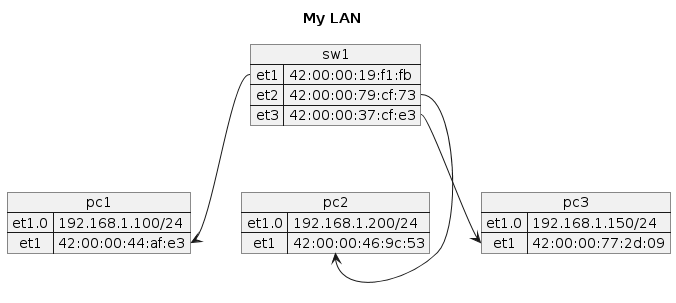

In [14]:
# let's refresh our memory on the link addresses
display(
    Image(
topology_diagram(homenetwork.name, homenetwork.get_topology()).png()
    )
)

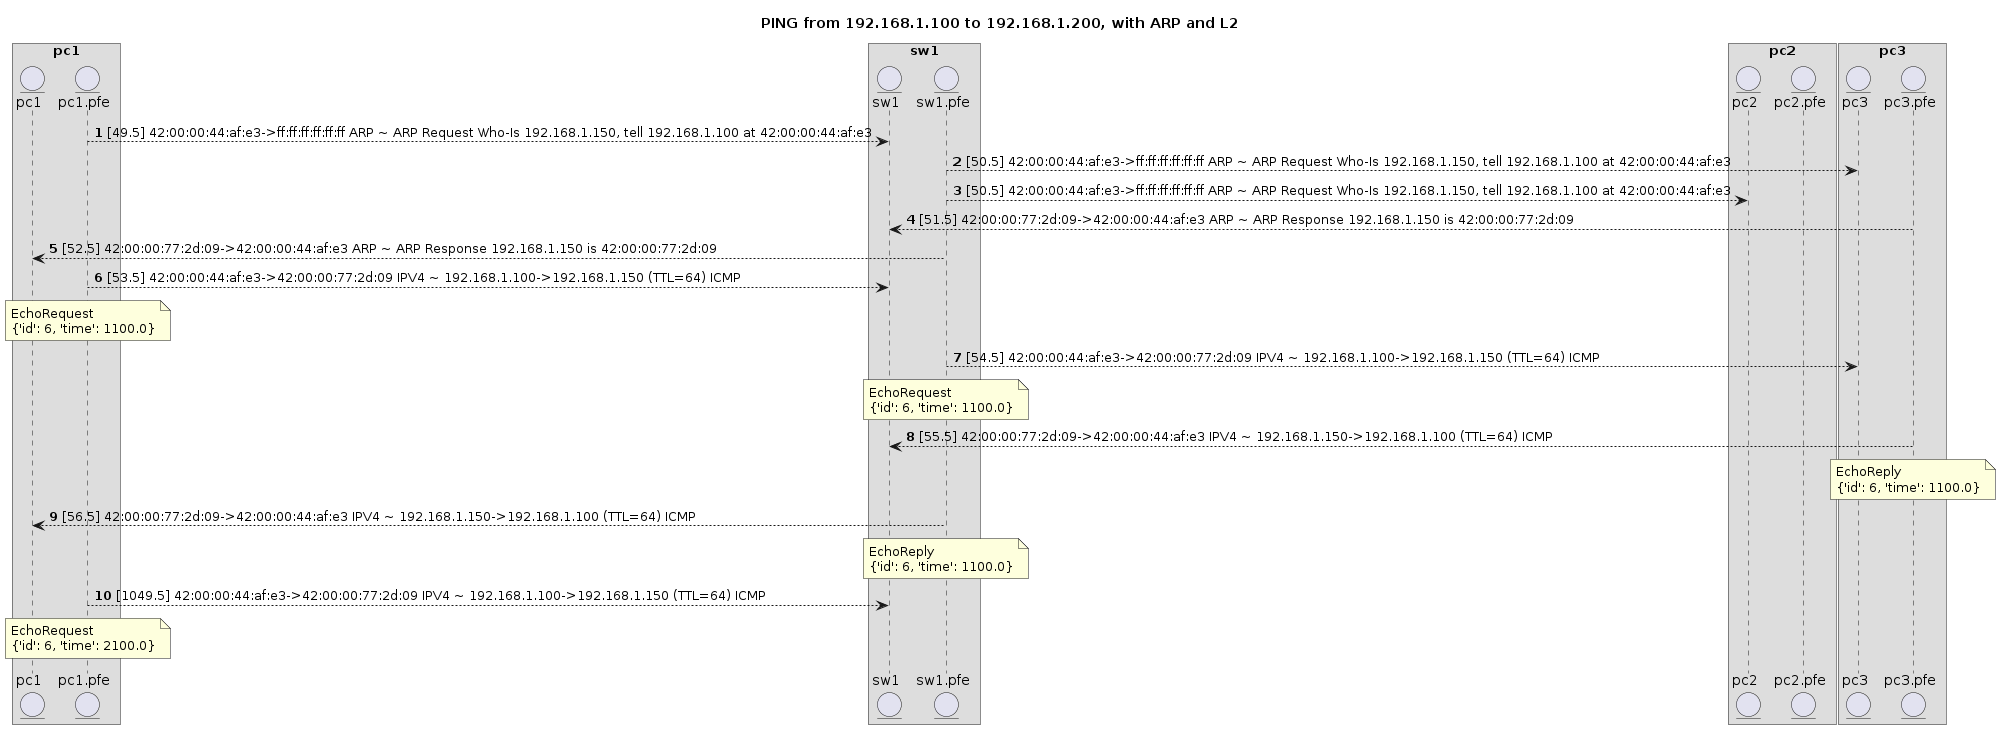

In [13]:
# Note use of frame_sequence here, which will render the L2 frames
display(
    Image(
        frame_sequence(
            "PING from 192.168.1.100 to 192.168.1.200, with ARP and L2", 
            [pc1, switch, pc2, pc3],
            events2,
        ).png()
    )
)

So what's happening here?

1. When PC1 sends out the ARP `Request`, by definition it doesn't know who the L2 recipient is, so it uses a special "broadcast" address of `ff:ff:ff:ff:ff:ff`. When SW1 receives that frame, it knows that it should copy the frame out and send it on all the connected ports.
2. The frame is forwarded to PC2 (`et2` on SW1)
3. The frame is forwarded to PC3 (`et3` on SW2)

Note that the frame is *NOT* forwarded back out `et1`, because that's the interface/port that the frame arrived on.

4. When PC3 sends back its response, it *does* know who the recipient, since it was contained in the `ARP` request as the "at" location.
5. SW1 forwards the message out `et1`, destined for PC1


And that's it!

Well... almost.

The one final question to answer: How did SW1 know *which interface* to send on to reach a particular MAC address? 

Is it turtles all the way down?

It uses a process called "MAC Learning" to figure it out automatically, *sort of like* how ARP `Requests` act like their own future reply.

Whenever the switch sees a frame come *IN* on an interface with a MAC source address (e.g. 42:00:00:44:af:e3 above for PC1 connected to `et1`),
it "learns" that most likely that MAC address can be reached via that interface. The next time a frame comes in *destined* for that address,
it just uses that lookup table to identify the interface.

Below you can see the learned mapping between MAC address and interface, which matches the topology diagram above. 

In [15]:
switch.run_junos_op("show ethernet-switching table")

MAC	Interface
42:00:00:44:af:e3	LOG/et1.1
42:00:00:46:9c:53	LOG/et2.1
42:00:00:77:2d:09	LOG/et3.1



Later demos may go into some implications/details of what might happen if the switch is connected to another switch.

But that's it for this one!

Some takeaways, if you'll have them:

* Any time you send a message, you need a destination (aka Address). When digging into networking or a new protocol, think about how the system is discovering *how to reach* that destination
* Network protocols are built up from a series of -- sometimes overlapping -- layers, each with its own addressing and discovery

